## Introduction

### Important note before beginning. I realised I made a mistake in my testing style and disregarded the auto correlation in the emcee algorithm. Noticing that error at 10PM April 17th fully changed my workflow. I have rewritten the entire notebook. If any part of this notebook seems like it is lacking a coherent flow or unmatching with the write up, please contact me at alikurmus@college.harvard.edu.

I chose the option of writing a Markov-Chain Monte-Carlo (MCMC) likelihood analysis algorithm and implementing it on a cosmological/astrophysical data set for the final project of Physics 212: Cosmology. The dataset I am going to focus on will be supernovae dataset and I will try to infer the cosmological parameters $h$, $\Omega_{M}$, $\Omega_{\Lambda}$ which are, respectively, the reduced Hubble constant, the matter density, and the dark energy density. The project emphasized the development of the MCMC algorithm itself in addition to the final outcome. Thus, I used multiple demonstrations to show that I can develop my own MCMC algorithm and can get the results from it; have sufficient understanding of MCMC concepts and simulations to use external libraries to deal with more complex data. 

The types of data analysis in this notebook include:
- Applying my MCMC algorithm to a bivariate Gaussian with correlated parameters to verify that algorithm works.
- Applying my MCMC algorithm to reduced SDSS-II/SNLS3 Supernova data provided by Imperial College Centre for Inference and Cosmology for a data analysis workshop intended for first/second year PhD students.
- Applying my MCMC algorithm to analyze more complicated data from [Phanteon+SH0ES Git Hub Data Release](https://github.com/PantheonPlusSH0ES/DataRelease/tree/main/Pantheon%2B_Data/4_DISTANCES_AND_COVAR).
- Comparisons of different algorithms.
- Tests of convergence and acceptance rate.
- Using the python library [emcee](https://emcee.readthedocs.io/en/stable/)  to verify my inference results.
## Theoretical Background

Type Ia supernovas can be considered as standard candles in our universe. They occur when the mass of a white dwarf exceeds Chandreshekar limit and electron degenaracy pressure is not enough to overcome the gravitational collapse. This results in all Type Ia Supernovas having similar luminosity. The distance of the TypeIa supernova can be found by relating the measured brightness to the known luminosity. The flux from a supernova with a Luminosity L is: <br>
$f = \frac{L}{4\pi D_L^2}$, where $D_L$ is the luminosity distance. Assuming a flat universe $\Omega_K = 0$ and $\Lambda CDM$ model to be true, the luminosity distance is expressed as <br>
$D_L = (1+z)\frac{c}{H_o}\cdot \int_{0}^{z} \frac{1}{\sqrt{\Omega_r (1 + z)^4 + \Omega_m (1 + z)^3 + \Omega_{\Lambda}}}$. $H_o = h \cdot 100 \rm{km}/sMpc$ <br>.

This formula comes from $$
\begin{aligned}
& D_{A}=\frac{a}{H_{0} \sqrt{\left|\Omega_{K}\right|}} \sinh \left(\chi H_{0} \sqrt{\Omega_{K}}\right), \quad\left(\Omega_{K}>0\right) \\
& D_{A}=a \chi, \quad\left(\Omega_{K}=0\right) \\
& D_{A}=\frac{a}{H_{0} \sqrt{\left|\Omega_{K}\right|}} \sin \left(\chi H_{0} \sqrt{-\Omega_{K}}\right), \quad\left(\Omega_{K}<0\right)
\end{aligned}
$$,
where $\chi(z)=\int_{0}^{z} d z^{\prime} / H\left(z^{\prime}\right)$ is the comoving distance to redshift $z$. $D_A$ and $D_L$ are related as $D_L = (1+z)^2 D_A$

### Shortcut Formula
For a flat universe we can use the formula mentioned in "Analytical Fit to the Luminosity Distance for Flat Cosmologies with a Cosmological Constant". In this formula we neglect the presence of radiation density. The contribution is irrelevant at low redshifts. Neglecting radiation density we can state $\Omega_{\Lambda} = 1 - \Omega_M$, $d_L = \frac{c}{H_0} (1+z) \left[\eta(1, \Omega_M) - \eta\left(\frac{1}{1+z}, \Omega_M\right)\right]$, where <br>
$\eta(a, \Omega_M) = 2\sqrt{s^3 + 1} \left[ \frac{1}{a^4} - 0.1540\frac{s}{a^3} + 0.4304\frac{s^2}{a^2} + 0.19097\frac{s^3}{a} + 0.066941s^4 \right]^{-\frac{1}{8}}$, and
$s^3 = \frac{1 - \Omega_M}{\Omega_M}$.

### Introducing the distance modulus

The distance is usually measured in distance modulus which is the difference between the appearent magnitude and absolute magnitude of the object.

The appearent magnitude $m$ is related to the flux by $m = -2.5 Log_{10}(F) + \text{constant}$ where the constant depends on what the brightness is measured with respect to. The absolute magnitude $M$ is what the appearent magnitude of an object would be if it were 10 parsecs away. The distance modulus is the difference between apparent magnitude and absolute magnitude. The distance modulus is calculated as $\mu = 5 Log_{10}(D_L) + 25$ when the distance is measured in Mpc. This is equivalent to $\mu = 5 Log_{10}(D_L) - 5$ if D_L was measured in parsecs. Throughout the code I will use different offsets for the distance modulus formula adjusted by the convenience of units my functions return. We can plot the theoretical predictions with different offsets and compare it with real data to see the units end up matching.

### Likelihood
We are trying to find the probability distribution of the cosmological parameters given the data. However, we can usually only calculate the probability of the data given the parameters. Luckily they are related by Bayes rule: <br>

$$  p(\theta|\vec{x}) \propto p(\theta)\mathcal{L}(\vec{x}|\theta)\,, $$

where $\theta$ is the cosmological parameters vector, $\vec{x}$ the input data and $\mathcal{L}(\vec{x}|\theta)$ is the likelihood function. $p(\theta)$ is the prior probibility of the parameters. However, as outlined in Lecture 21, the prior will not matter if the data is informative. This means we can assume a flat or log flat prior to make our calculations easier.

Assuming that our errors are Gaussian as a result of Central Limit Theorem and using the distance modulus, we can have a likelihood function as

$\mathcal{L}(\vec{\mu}|\theta)) =  \frac{1}{\sqrt{(2\pi)^k |C|}}\exp\left( -\frac{1}{2} \sum_{i,j=1}^{n} [\mu_i - \mu_{th}(z_i, \theta)] C^{-1}_{ij} [\mu_j - \mu_{th}(z_j, \theta)] \right)$, where $\theta$ is te array of parameters and $C$ is the covariance matrix, $k$ is the dimension of covariance matrix. The factor in front of the exponential normalizes the likelihood.

### A note about log of the likelihood
The parameters that maximize the likelihood would be the parameters that the data suggests that are most likely to be describing the system. Because logarithm is a strictly increasing function, maximizing log of the likelihood is equivalent to maximizing likelihood. In times where the python will struggle to handle very small data, it would be useful to work with log of the likelihood.

## Data Used For Analysis
- The reduced SDSS-II/SNLS3 Supernova data and covariance matrix provided by Imperial College Centre for Inference and Cosmology are available on their website for data analysis [workshops](http://astro.ic.ac.uk/content/icic-data-analysisworkshop-2016). The original data can be found [SDSS-II/SNLS3](https://supernovae.in2p3.fr/sdss_snls_jla/ReadMe.html).
- The the data of 1701 supernovae events from the [Phanteon+SH0ES Git Hub Data Release](https://github.com/PantheonPlusSH0ES/DataRelease/tree/main/Pantheon%2B_Data/4_DISTANCES_AND_COVAR) colaboration is available on Github.

## My MCMC Algorithm
I developed a Metropolis hastings style algorithm that takes either a likelihood or log of the likelihood function, a proposal function, and step size as an input. The algorithm then returns the array of parameter values from the result and the acceptance rate of the simulation. The array of parameters can then be used for plotting corner plots and probability distributions of the parameters. The algorithm also lets the user determine a certain burnin period (either an absolute number or a ratio of the step size) for the simulation to forget where it started. 

A new state is proposed based on a Gaussian centered around the current parameter value with a standard deviation indicated by the step size. The simple breakdown of the algorithm is as follows:
1. Start from a state.
2. Calculate the likelihood.
3. Go to another state based on the proposal function.
   - The current algorithm uses the proposal function described above but it could be anything.
4. Compare the likelihoods of the current state and the proposal state.
5. If the proposal state has a higher likelihood, go to the proposal state.
6. If the current state has a higher likelihood:
   - Generate a number between 0 and 1.
   - If the ratio of proposed likelihood to current likelihood is higher than the generated number:
     - Go to the proposed state. This lets the algorithm avoid local minimums. <br>
   - Else:
     - Stay in the current state.
7. Repeat steps 1 to 6 starting with the current state.

In [4]:
def mcmc_updater(curr_state, curr_likeli, likelihood, proposal_distribution, steps=[0.1, 0.1, 0.1], log=False, *args, **kwargs):
    """
    Propose a new state and compare the likelihoods or log likelihoods based on the 'log' flag.
    """
    proposal_state = proposal_distribution(curr_state, steps)
    accepted = 0

    # Calculate the proposed likelihood or log likelihood
    if log:
        prop_likeli = likelihood(proposal_state, *args, **kwargs)
        # Calculate the acceptance criterion based on the difference in log likelihoods
        delta_log_likeli = prop_likeli - curr_likeli
        accept_crit = np.exp(delta_log_likeli)  # exp of difference for log likelihood ratio
    else:
        prop_likeli = likelihood(proposal_state, *args, **kwargs)
        # Calculate the acceptance criterion based on the ratio of likelihoods
        accept_crit = prop_likeli / curr_likeli

    accept_threshold = np.random.uniform(0, 1)

    # Accept or reject the proposal based on the acceptance criterion
    if accept_crit > accept_threshold:
        accepted = 1
        return proposal_state, prop_likeli, accepted

    return curr_state, curr_likeli, accepted

def proposal_distribution(theta, steps=[0.1,0.1,0.1]):
    """
    Gaussian proposal distribution.
    The new state is proposed by choosing a value from a Gaussian centered
    around the old value with a standard deviation indicated in steps.
    """
    return np.random.normal(theta, steps)

def find_mcmc_acceptance(likelihood, proposal, step=[0.01, 0.01, 0.01], initial=[0.31, 0.69, 0.67],
                         num_steps=10000, burnin=0.1, log=False, *args, **kwargs):
    """
    Run MCMC to find the acceptance rate and samples, using either likelihood or log likelihood.
    Shows progress and iteration rate using tqdm.
    """
    samples = []
    current_state = initial
    current_likeli = likelihood(current_state, *args, **kwargs)
    total_acceptance = 0

    idx_burnin = int(burnin * num_steps) if (0 <= burnin) and (1 >= burnin) else burnin
    num_valid_steps = num_steps - idx_burnin

    # Wrap the range with tqdm for progress indication
    for i in tqdm(range(num_steps), desc='MCMC Progress'):
        current_state, current_likeli, acceptance = mcmc_updater(
            curr_state=current_state,
            curr_likeli=current_likeli,
            likelihood=likelihood,
            proposal_distribution=proposal,
            steps=step,
            log=log,
            *args, **kwargs
        )

        if i >= idx_burnin:
            samples.append(current_state)
            total_acceptance += acceptance

    acceptance_rate = total_acceptance / num_valid_steps
    return samples, acceptance_rate

### Import the necessary libraries
All of the packages are available on conda and pip package distribution.

In [1]:
# all of the packages are available in the conda distribution
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from scipy.integrate import quad
from scipy.interpolate import interp1d # Interpolation function
import emcee
import corner
from scipy.stats import norm, chisquare
from emcee import EnsembleSampler
from emcee.backends import HDFBackend
from tqdm import tqdm  # Import tqdm for the progress bar

## Testing My MCMC Algorithm On A Known Distribution
Before applying the algorithm on a real dataset, I want to test it with a known distribution. The goals of this test is to show that
the algorithm can reproduce the distribution of a known multivariate normal with correlated parameters. It should be able to reproduce the distribution regardless of the starting point. Here is the breakdown of the test:
- Setup a bivariate gaussian distribution with correlated parameters centered at 0 and 1 with a standard deviation of 1.
- Start from an initial state that is 5 standard deviations away from the original value.
- Observe if the algorithm converges to the target distribution.

Note: This test can also be used to determine the effect of step size on the acceptance rate and the speed of the algorithm for a target Gaussian distribution.

In [2]:
# define a bivariate normal distribution likelihood
def likelihood_toy(theta):
    # A bivariate normal distribution likelihood
    mean = np.array([0, 1])
    covariance = np.array([[1, 0.5], [0.5, 1]])  # example of correlated parameters
    return np.exp(-0.5 * (theta - mean).T @ np.linalg.inv(covariance) @ (theta - mean)) / (2 * np.pi * np.sqrt(np.linalg.det(covariance)))

In [8]:
# make the test starting from values 5 standard deviation away from the truth
samples_toy, acceptance_toy = find_mcmc_acceptance(likelihood_toy, proposal_distribution,
                                                   step=[0.5, 0.5], initial=[5, -5], num_steps=300000, burnin=10000)

MCMC Progress: 100%|█████████████████| 300000/300000 [00:05<00:00, 54486.70it/s]


In [9]:
# convert the final function to an array
samples_toy = np.array(samples_toy)

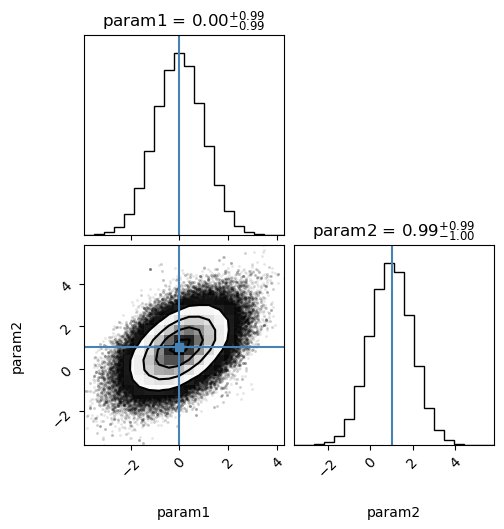

In [10]:
fig = corner.corner(
    samples_toy, labels=['param1', 'param2'], show_titles=True, truths=[0,1]
)

This verifies that the algorithm works.

## Explore The Real Data and Define Functions Theoretical $D_L$ and $\mu$
I will use two approaches to calculate $D_L$ and $\mu$:
- Using the fitting formula above and only using two parameters: $\Omega_{M}$, $h$
- Using the full $\Lambda$CDM model distance and including: $\Omega_{M}$, $\Omega_{\Lambda}$, $h$

### Load the data
The ICIC data and covariance matrix was available as flat text files. The PANTHEON+SHOES data was available in .dat format and the covariance matrix was in .cov form. I converted both data to csv files and covariance matrices to numpy arrays. I am skipping the data import and conversation steps as they are trivial and would cause digression. The ICIC reduced data will be for testing.

I am calculating the inverses and eigenvalues of the covariance matrices in advance.

In [11]:
# the data from ICIC, the data is averaged in 31 narrow bins
simple_obs = pd.read_csv('z_mu_data.csv')
z_data = simple_obs['z']
mu_data = simple_obs['mu']
# covariance matrix for ICIC data (31 x 31)
cov_simple = np.load('simple_cov.npy')
cov_inv = np.linalg.inv(cov_simple)
# eigenvalues for the data needed
cov_eigvals_sim = np.linalg.eig(cov_simple)[1]
log_det_sim = np.sum(np.log(np.absolute(cov_eigvals_sim)))
cov_len_sim = len(cov_simple)

# the data from PANTHEON+SHOES Collaboration
pantheon_obs = pd.read_csv('pantheon_obs.csv', index_col=0)
# covariance matrix from the data (1701 x 1701)
# additionally complicated
cov_matrix2 = np.load('pantheon_cov.npy')
z_data2 = pantheon_obs['zCMB'].values
mu_data2 = pantheon_obs['MU_SH0ES'].values
inv_cov_matrix2 = np.linalg.inv(cov_matrix2)
# eigenvalues of the data needed to calculate determinant
cov_eigvals2 = np.linalg.eig(cov_matrix2)[1]
# direct calculation of log gives 0, will demonstrate later
# use the fact the determinant is the product of eigenvalues
log_det = np.sum(np.log(np.absolute(cov_eigvals2)))
cov2_len = len(cov_matrix2)

In [12]:
# calculate \eta mentioned in the fitting formula
def eta(a, Omega_M):
    s3 = (1 - Omega_M) / Omega_M
    s = s3**(1/3)
    eta = 2*np.sqrt(s3+1)*(
        1/a**4 - 0.1540*s/a**3 + 0.4304*s**2/a**2 + 0.19097*s**3/a + 0.066941*s**4
    )**(-1/8)
    return eta

# function to calculate the distance modulus using the fitting formula
# it should be faster than calculating the integrals
def calculate_mu_th_fast(z, Omega_M, h):
    c = 3 * 10 ** 8
    H0 = h * 100
    Omega_Lambda = 1 - Omega_M
    a = 1 / (1 + z)
    dL = (c / H0) * (1 + z) * (eta(1, Omega_M) - eta(a, Omega_M))
    mu_th = 5 * np.log10(dL) + 10
    return mu_th

# function to calculate distance modulus with the full model
# include interpolation function, it may be overkill
# but it does get rid of the possible redshift errors
def calculate_mu_th(z_data, Omega_M, Omega_L, h):
    c = 3 * 10**8
    H0 = h * 100 / (3.086 * 10**19)  # H0 in 1/s
    z_test = np.linspace(0.001, 2.5, 1701)
    # Function to calculate the integrand
    def integrand(z, Omega_m, Omega_Lambda):
        Omega_r = 9 * 10**(-5)
        return 1 / np.sqrt(Omega_r * (1 + z)**4 + Omega_m * (1 + z)**3 + Omega_Lambda)
    
    def dl(z, Omega_m, Omega_Lambda, H0):
        integral, _ = quad(integrand, 0, z, args=(Omega_m, Omega_Lambda))
        return ((1 + z) * (c / H0) * integral) / (3.086 * 10**22)
    
    dL_values = [dl(z, Omega_M, Omega_L, H0) for z in z_test]
    mu_model = 5 * np.log10(np.abs(dL_values)) + 25
    mu_model_inter = interp1d(z_test, mu_model, kind='cubic')
    mu_model_data = mu_model_inter(z_data)
    return mu_model_data

# function to calculate the distance modulus with no interpolation
def calculate_mu_th_no_interpolate(z_data, Omega_M, Omega_L, h):
    c = 3 * 10**8
    H0 = h * 100 / (3.086 * 10**19)  # H0 in 1/s
    # Function to calculate the integrand
    def integrand(z, Omega_m, Omega_Lambda):
        Omega_r = 9 * 10**(-5)
        return 1 / np.sqrt(Omega_r * (1 + z)**4 + Omega_m * (1 + z)**3 + Omega_Lambda)
    
    def dl(z, Omega_m, Omega_Lambda, H0):
        integral, _ = quad(integrand, 0, z, args=(Omega_m, Omega_Lambda))
        return ((1 + z) * (c / H0) * integral) / (3.086 * 10**22)
    
    dL_values = [dl(z, Omega_M, Omega_L, H0) for z in z_data]
    mu_model = 5 * np.log10(np.abs(dL_values)) + 25
    return mu_model

### Plot the functions against the actual data to see

In [13]:
mu_th_fast = calculate_mu_th_fast(z_data2, 0.32, 0.67)
mu_th_fancy = calculate_mu_th(z_data2, Omega_M=0.32, Omega_L=0.68, h=0.67)

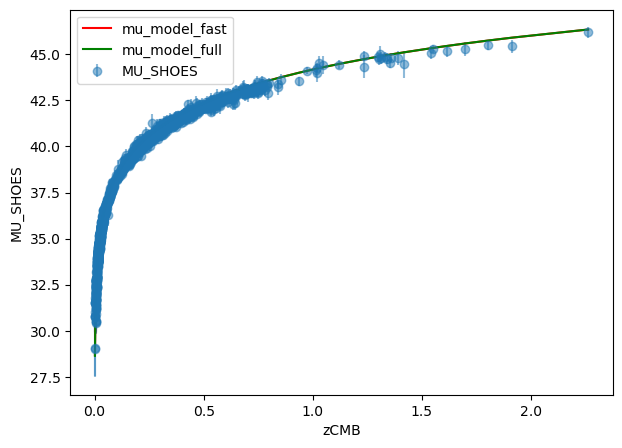

In [193]:
fig_mu, axes = plt.subplots(figsize=(7,5))
axes.errorbar(x=z_data2, y=mu_data2, yerr=pantheon_obs['MU_SH0ES_ERR_DIAG'], fmt='o', label='MU_SHOES', alpha=0.5)
axes.set_xlabel('zCMB')
axes.set_ylabel('MU_SHOES')
axes.plot(z_data2, mu_th_fast, 'r', label='mu_model_fast')
axes.plot(z_data2, mu_th_fancy, 'g', label='mu_model_full')
axes.legend()

In [194]:
fig_mu.savefig('mu_fast_slow.pdf', bbox_inches='tight')

This shows that both the fast model with the fit and full treatment produce very similar result. The paper that introduces the fitting formula states that it has 0.4% error. That should be indistinguishable in this scale.

## Testing the algorithm on simple data designed for the ICIC workshop

In [15]:
# We can assume a flat prior and just use the likelihood as the target distribution
# In fact we don't need to normalize the likelihood for this case
def likelihood_simple(theta, z_data=z_data, mu_data=mu_data, cov_inv=cov_inv):
    omega_m, h = theta
    mu_th = calculate_mu_th_fast(z_data, omega_m, h)
    like = np.exp(-(0.5 * np.matmul((mu_data - mu_th), np.matmul(cov_inv, (mu_data - mu_th)))))
    return like

In [17]:
# first verify that the simplified dataset works
samples, acceptance = find_mcmc_acceptance(likelihood_simple, proposal_distribution,
                                           step=[0.1, 0.1], initial=[0.3, 0.69],
                                           num_steps=200000, burnin=10000,
                                           z_data=z_data, mu_data=mu_data, cov_inv=cov_inv)

MCMC Progress:   0%|                                 | 0/200000 [00:00<?, ?it/s]/var/folders/ss/xpl4rz6x099dxtmc5h_96sr00000gn/T/ipykernel_10827/3153677268.py:4: RuntimeWarning: invalid value encountered in scalar power
  s = s3**(1/3)
/var/folders/ss/xpl4rz6x099dxtmc5h_96sr00000gn/T/ipykernel_10827/3153677268.py:5: RuntimeWarning: invalid value encountered in sqrt
  eta = 2*np.sqrt(s3+1)*(
MCMC Progress: 100%|██████████████████| 200000/200000 [01:33<00:00, 2140.48it/s]


This was just a verification that the function works. The optimization comparisons will be made later.

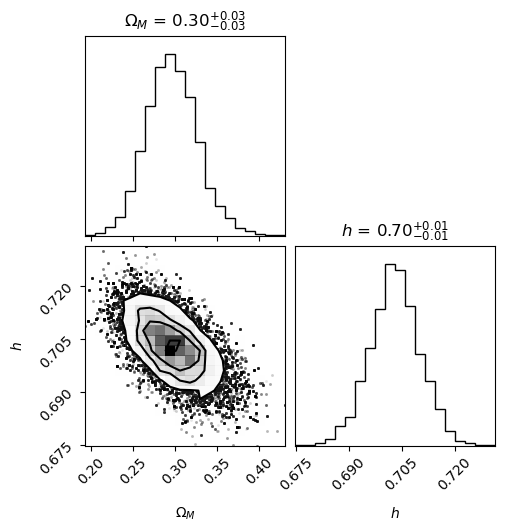

In [18]:
fig = corner.corner(
    np.array(samples), show_titles=True, labels=[r'$\Omega_M$', r'$h$']
)

This test shows that the algorithm can output the distributions for a previously unknown distribution. This test is also a demonsration that the algorithm can work with regular likelihoods and one can decide to choose regular or log of the likelihood. I note that I am not going to use these results to make an inference as they came from a data simplified for a workshop.

## Applying the Algorithm On The Actual Complicated Data
Now it is time to apply the algorithm to the actual data. Unfortunately we can't use the simplified likelihood. We also have to use multiple additional trick due to nature of the data. The determinant of the covariance matrix of the PANTHEON+SHOES data is so small that python considers it zero. However, the inverse of the matrix still exists which should not be possible unless the determinant calculation has an error. We can see the line ``inv_cov_matrix2 = np.linalg.inv(cov_matrix2)`` got executed without an error.

In [19]:
# check the determinant of the matrix
np.linalg.det(cov_matrix2)

0.0

In [20]:
# check the determinant as multiples of eigenvalues
np.prod(cov_eigvals2)

-0.0

In [21]:
# now check the log determinant as a sum of the log of the eigenvalues
# np.linalg.slogdet also does not give an accurate result
log_det

-19035763.05709705

To deal with this, we define a log likelihood function. We can also directly use this and assume a prior that is flat in the logarithmic scale. Calculating the log of our current Gaussian likelihood will also increase the efficieny of the algorithm.

In [22]:
# define a fast likelihood calculation function using the fitting formula
def log_likelihood_fast(theta, z_data=z_data, mu_data=mu_data, cov_inv=cov_inv, log_det=log_det, cov_len=cov2_len):
    omega_m, h = theta
    mu_th = calculate_mu_th_fast(z_data, omega_m, h)
    log_like = -(0.5 * np.matmul((mu_data - mu_th), np.matmul(cov_inv, (mu_data - mu_th))))
    N = cov_len
    # log_det = np.sum(np.log(np.absolute(cov_eigvals)))
    log_normalize = 0.5 * N * np.log(2*np.pi) + 0.5 * log_det
    return log_like - log_normalize

In [24]:
# now apply the algorithm to the complicated dataset where
# the covariance matrix is 1701x1701 rather than 31x31
samples5, acceptance5 = find_mcmc_acceptance(log_likelihood_fast, proposal_distribution,
                                           step=[0.02, 0.02], initial=[0.31, 0.67],
                                           num_steps=300000, burnin=10000, log=True,
                                           z_data=z_data2, mu_data=mu_data2,
                                             cov_inv=inv_cov_matrix2, log_det=log_det, cov_len=cov2_len)

MCMC Progress:   0%|                                 | 0/300000 [00:00<?, ?it/s]/var/folders/ss/xpl4rz6x099dxtmc5h_96sr00000gn/T/ipykernel_10827/2353296613.py:13: RuntimeWarning: overflow encountered in exp
  accept_crit = np.exp(delta_log_likeli)  # exp of difference for log likelihood ratio
MCMC Progress: 100%|██████████████████| 300000/300000 [02:47<00:00, 1790.69it/s]


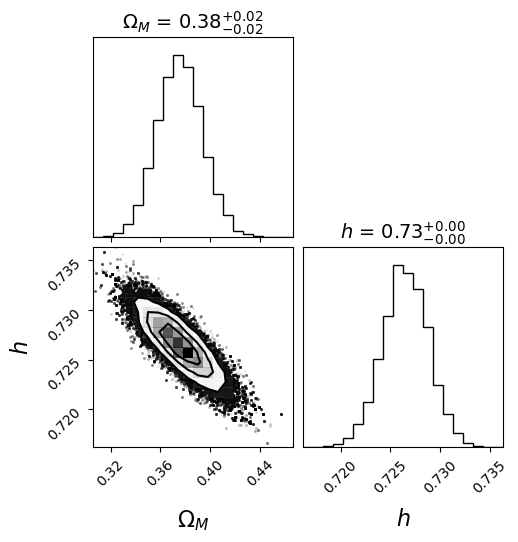

In [88]:
fig = corner.corner(
    np.array(samples5), show_titles=True, label_kwargs={"fontsize": 16}, title_kwargs={"fontsize": 14}, labels=[r'$\Omega_M$', r'$h$']
)

In [89]:
fig.savefig('corner_2D.pdf', bbox_inches='tight')

In [26]:
samples_from_fit = np.array(samples5)

The algorithm had an estimate of of the hubble constant consistent with the papers written by PANTHEON+ and SHOES colloboration. The matter density, although looks like an overestimate, still is within the confidence interval of SDSS data. I will make more detailed fits to these disributions. **Using the fitting formula and log of the likelihood still let the algorithm have 1800 samples per second with a complicated data and covariance matrix.**

## Using an external library for data analysis
The analysis with my algorithm gave clear results. However it seems to be overestimating the $\Omega_M$. Thus it may be better to use an external library and compare the results. The external library is already fast enough.

Python emcee library uses multiple chains that communicate with each other to make sure convergence and avoid local minima. It also allows for parallelization. It is a more advanced version of an MCMC that still uses Metropolis Hastings.

In [75]:
# define a log likelihood function that uses the full model and leaves no rooms for error
def log_likelihood_full2(theta, z_data, mu_data, cov_inv, log_det, cov_len):
    omega_m, omega_l, h = theta
    mu_th = calculate_mu_th(z_data, omega_m, omega_l, h)
    log_like = -(0.5 * np.matmul((mu_th - mu_data), np.matmul(cov_inv, (mu_th- mu_data))))
    N = cov_len
    log_normalize = 0.5 * float(N) * np.log(2*np.pi) + 0.5 * log_det
    return log_like - log_normalize

# the same function that does not interpolate
# yes we could have written "better code" by combining the two functions above
# and using an if statement, but when you run a code a million times every detail matters
def log_likelihood_no_interpolate(theta, z_data, mu_data, cov_inv, log_det, cov_len):
    omega_m, omega_l, h = theta
    mu_th = calculate_mu_th_no_interpolate(z_data, omega_m, omega_l, h)
    log_like = -(0.5 * np.matmul((mu_th - mu_data), np.matmul(cov_inv, (mu_th- mu_data))))
    N = cov_len
    log_normalize = 0.5 * float(N) * np.log(2*np.pi) + 0.5 * log_det
    return log_like - log_normalize

def log_probability3(theta, z_data, mu_data, cov_inv, log_det, cov_len):
    lp = log_prior2(theta)
    if not np.isfinite(lp):
        return -np.inf
    return lp + log_likelihood_full2(theta, z_data, mu_data, cov_inv, log_det, cov_len)

## Fitting Gaussians To Distributions
Both my algorithm and emcee showed that the distribution of the parameters are Gaussian. Lets fit Gaussians to these distributions to make sure the data actually follows a Gaussian and not a visual artifact.

In [39]:
def plot_histograms_with_gaussian_fit_and_stats_fancy(data, param_list):
    num_params = data.shape[1]
    parameter_names = param_list
    num_bins = 50  # Number of bins for the histogram
    fig, axs = plt.subplots(num_params, 1, figsize=(7, 4 * num_params))

    if num_params == 1:
        axs = [axs]  # Make axs a list if there is only one subplot

    # Plot a histogram and Gaussian fit for each parameter
    for i, ax in enumerate(axs):
        param_data = data[:, i]
        # Histogram with density=True for normalization
        counts, bins, patches = ax.hist(param_data, bins=num_bins, density=True, alpha=0.6, color='b', label='Histogram')
        bin_centers = (bins[:-1] + bins[1:]) / 2
        bin_width = np.mean(np.diff(bins))  # Average bin width

        # Fit a Gaussian
        mu, std = norm.fit(param_data)
        x = np.linspace(bins.min(), bins.max(), 300)
        p = norm.pdf(x, mu, std)  # Scale PDF by bin width
        
        # Plot Gaussian
        ax.plot(x, p, 'k', linewidth=2, label=f'Fit: μ={mu:.4f}, σ={std:.4f}')
        ax.set_title(f'Distribution and Gaussian Fit for {parameter_names[i]}')
        ax.set_ylabel('Probability Density (%)')

        num_entries = len(param_data)
        ticks = ax.get_yticks()
        new_ticks = ticks * bin_width * 100 # Convert density ticks to approximate counts
        ax.set_yticklabels([f"{round(tick, 1)}" for tick in new_ticks])
        
        ax.legend()

    axs[-1].set_xlabel('Parameter Values', fontsize=13)
    plt.tight_layout()
    plt.show()
    return fig, axs  # Return figure and axes for further manipulation if needed

### Make a plot for the result of fitting function

/var/folders/ss/xpl4rz6x099dxtmc5h_96sr00000gn/T/ipykernel_10827/3426631614.py:31: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_yticklabels([f"{round(tick, 1)}" for tick in new_ticks])
/var/folders/ss/xpl4rz6x099dxtmc5h_96sr00000gn/T/ipykernel_10827/3426631614.py:31: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_yticklabels([f"{round(tick, 1)}" for tick in new_ticks])


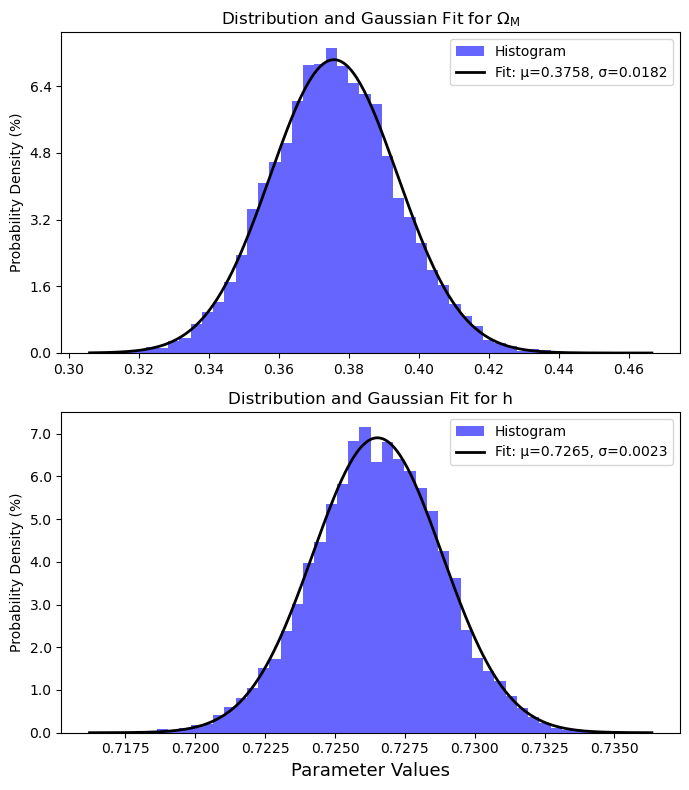

In [40]:
fig_test2, axes2 = plot_histograms_with_gaussian_fit_and_stats_fancy(samples_from_fit, [r"$\Omega_\text{M}$", "h"])

In [43]:
fig_test2.savefig('manual_mcmc_best_gaussian_fits.pdf', bbox_inches='tight')

## See how the best fit parameters compare
We see that the faster algorithm applies to higher redshift better.

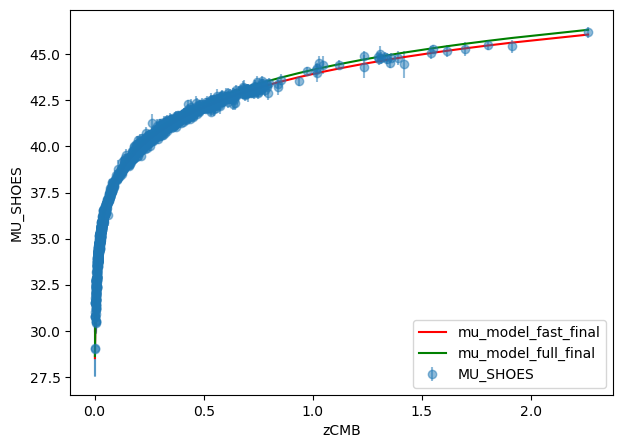

In [47]:
mu_th_fast2 = calculate_mu_th_fast(z_data2, 0.3758, 0.7265)
mu_th_fancy2 = calculate_mu_th(z_data2, Omega_M=0.3219, Omega_L=0.6771, h=0.6743)
fig, axes = plt.subplots(figsize=(7,5))
axes.errorbar(x=z_data2, y=mu_data2, yerr=pantheon_obs['MU_SH0ES_ERR_DIAG'], fmt='o', label='MU_SHOES', alpha=0.5)
axes.set_xlabel('zCMB')
axes.set_ylabel('MU_SHOES')
axes.plot(z_data2, mu_th_fast2, 'r', label='mu_model_fast_final')
axes.plot(z_data2, mu_th_fancy2, 'g', label='mu_model_full_final')
axes.legend()

We see that the difference of the predictinons increase as the redshift increases. The difference is less than 1 percent even at the maximum difference. In fact, it looks like the fast algorithm fit the higher redshift better.

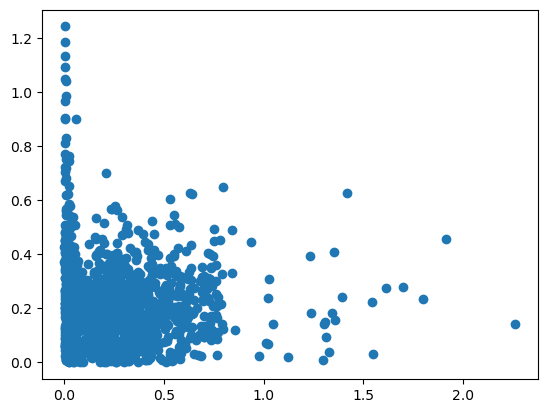

In [48]:
plt.scatter(z_data2, abs(mu_th_fancy2- mu_data2))

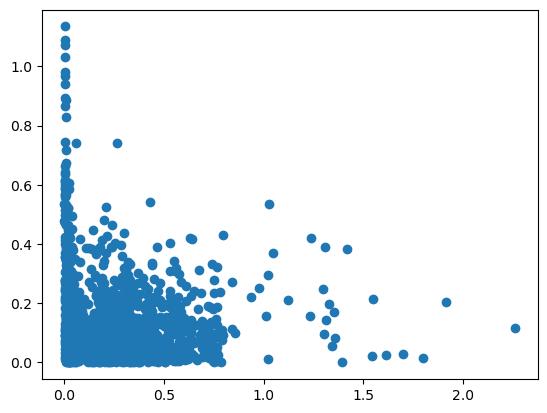

In [49]:
plt.scatter(z_data2, abs(mu_th_fast2- mu_data2))

### Test if the emcee algorithm yields the same results as the manual algorithm in a reduced dataset.

In [50]:
def likelihood_simple(theta, z_data=z_data, mu_data=mu_data, cov_inv=cov_inv):
    omega_m, h = theta
    mu_th = calculate_mu_th_fast(z_data, omega_m, h)
    like = np.exp(-(0.5 * np.matmul((mu_data - mu_th), np.matmul(cov_inv, (mu_data - mu_th)))))
    return like

def log_prior_simple(theta):
    Omega_m, h = theta # Initial parameters guess
    if 0.29 < Omega_m < 0.4 and 0.65 < h < 0.75:
        return 0.0
    return -np.inf

def log_prob_simple(theta, z_data, mu_data, cov_inv, log_det, cov_len):
    lp = log_prior_simple(theta)
    if not np.isfinite(lp):
        return -np.inf
    return lp + log_likelihood_fast(theta, z_data=z_data, mu_data=mu_data, cov_inv=cov_inv, log_det=log_det_sim, cov_len=cov_len_sim)

In [54]:
initial_simple = [0.32, 0.67]
# Define the initial position and less number of chains
initial_pos_simple = initial_simple + 10**(-1)*np.random.randn(100, 2)
nwalkers_simple, ndim_simple = initial_pos_simple.shape

sampler_sim = emcee.EnsembleSampler(nwalkers_simple, ndim_simple,
                                    log_prob_simple, args=(z_data, mu_data, cov_inv, log_det_sim, cov_len_sim))
sampler_sim.run_mcmc(initial_pos_simple, 25000, progress=True);

  0%|                                                 | 0/25000 [00:00<?, ?it/s]/Users/ali/opt/miniforge3/envs/cosmology/lib/python3.12/site-packages/emcee/moves/red_blue.py:99: RuntimeWarning: invalid value encountered in scalar subtract
  lnpdiff = f + nlp - state.log_prob[j]
100%|█████████████████████████████████████| 25000/25000 [12:27<00:00, 33.44it/s]


We can see that emcee struggles with an unnormalized log likelihood function.

In [55]:
flat_samples_sim = sampler_sim.get_chain(discard=100, thin=15, flat=True)

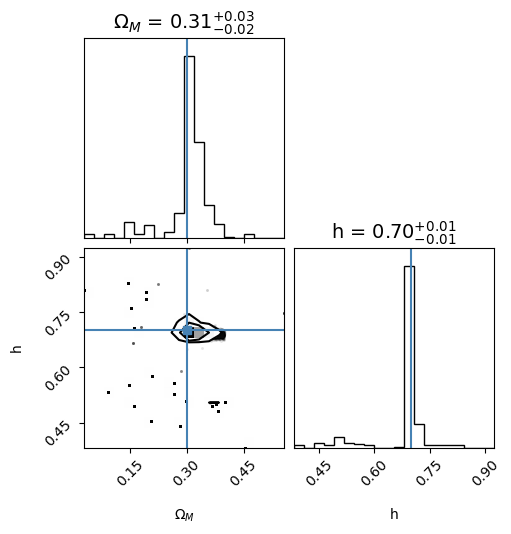

In [56]:
# make the plots with truth values from the Planck colloboration
fig = corner.corner(
    flat_samples_sim, labels=[r"$\Omega_M$", "h"], show_titles=True, title_kwargs={"fontsize": 14}, truths=[0.3, 0.7]
)

In [96]:
sampler_comp = emcee.EnsembleSampler(nwalkers_simple, ndim_simple,
                                    log_prob_simple, args=(z_data2, mu_data2, inv_cov_matrix2, log_det, cov2_len))
sampler_comp.run_mcmc(initial_pos_simple, 1000, progress=True);

100%|███████████████████████████████████████| 1000/1000 [11:49<00:00,  1.41it/s]


In [97]:
flat_comp = sampler_comp.get_chain(discard=100, thin=15, flat=True)

In [113]:
np.mean(flat_comp[:, 0])

0.3523442100430552

In [114]:
np.mean(flat_comp[:, 1])

0.7056431603692153

After running a very short chain we see that emcee also results in similar values with the manual algorithm. Thus, the resulting difference could be the difference between using 2 and 3 parameters.

### Now try analyzing the reduced data with 3 parameters using emcee

In [59]:
sampler7 = emcee.EnsembleSampler(nwalkers, ndim, log_probability3, args=(z_data, mu_data, cov_inv, log_det_sim, cov_len_sim))
sampler7.run_mcmc(initial_pos, 25000, progress=True);

100%|████████████████████████████████████| 25000/25000 [02:42<00:00, 153.90it/s]


We see that number of iterations per second become so much larger or algorithm becomes so much faster even when we increase the number of chains. This is due to choosing the probability function in a restrictive way. The previous simulation was only able to get 30 iterations per seconds.

In [60]:
flat_samples_sim7 = sampler7.get_chain(discard=100, thin=15, flat=True)

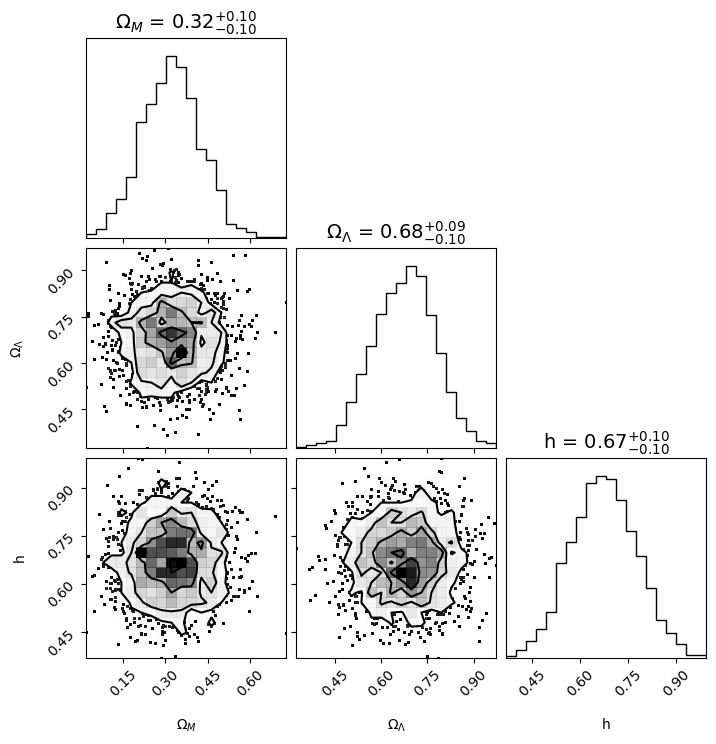

In [61]:
fig = corner.corner(
    flat_samples_sim7, labels=labels, show_titles=True, title_kwargs={"fontsize": 14},
)

When we analyse with three parameters instead of 2, we tend to get lower matter constant $\Omega_M$ and hubble constant $h$.

## Compare the efficiency of the fast and full model function.
We see that inferring three parameters may produce more correct results. However, only inferring two significantly increases the speed. Lets see how fast we can go.

In [64]:
# first verify that the simplified dataset works
samples8, acceptance8 = find_mcmc_acceptance(log_likelihood_full2, proposal_distribution,
                                           step=[0.02, 0.02, 0.02], initial=[0.31, 0.68, 0.67],
                                           num_steps=10000, burnin=0.1, log=True,
                                           z_data=z_data, mu_data=mu_data,
                                             cov_inv=cov_inv, log_det=log_det_sim, cov_len=cov_len_sim)

MCMC Progress:  20%|████▋                  | 2047/10000 [01:11<04:39, 28.45it/s]


KeyboardInterrupt: 

I interrupted the function because it only was able to have around 30 iterations per second when we were using the full model. Now checkout the integral fitting function.

In [69]:
# first verify that the simplified dataset works
samples9, acceptance9 = find_mcmc_acceptance(log_likelihood_fast, proposal_distribution,
                                           step=[0.02, 0.02], initial=[0.31, 0.67],
                                           num_steps=20000, burnin=0.1, log=True,
                                           z_data=z_data, mu_data=mu_data,
                                             cov_inv=cov_inv, log_det=log_det_sim, cov_len=cov_len_sim)

MCMC Progress: 100%|████████████████████| 20000/20000 [00:09<00:00, 2150.03it/s]


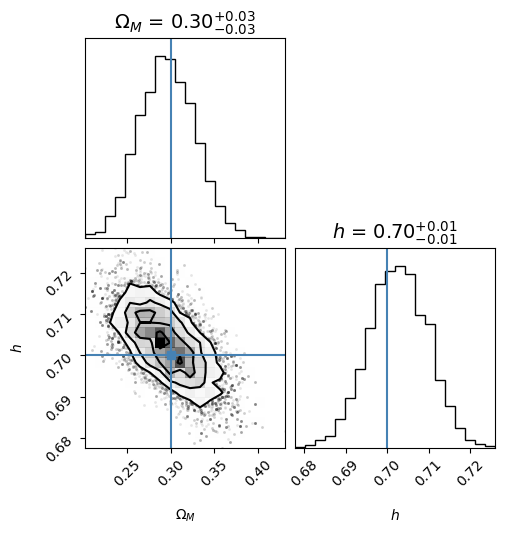

In [102]:
fig = corner.corner(
    np.array(samples9), labels=[r'$\Omega_M$', r'$h$'], show_titles=True, title_kwargs={"fontsize": 14}, truths=[0.3, 0.7]
)

Using the fitting formula makes the chain converge faster and also allows 2150 iterations per seconds, which is 100 times faster compared to using the full model.

### Compare the algorithms in more complex data
Now lets see if having a more complicated data increases the difference between the speed of the algorithms. In fact to make the full model faster, I will not include the interpolation feauture.

In [76]:
# first verify that the simplified dataset works
samples10, acceptance10 = find_mcmc_acceptance(log_likelihood_no_interpolate, proposal_distribution,
                                           step=[0.02, 0.02, 0.02], initial=[0.31, 0.68, 0.67],
                                           num_steps=100000, burnin=0.1, log=True,
                                           z_data=z_data2, mu_data=mu_data2,
                                             cov_inv=inv_cov_matrix2, log_det=log_det, cov_len=cov2_len)

MCMC Progress:   0%|                         | 3/100000 [00:00<59:35, 27.97it/s]/var/folders/ss/xpl4rz6x099dxtmc5h_96sr00000gn/T/ipykernel_10827/2353296613.py:13: RuntimeWarning: overflow encountered in exp
  accept_crit = np.exp(delta_log_likeli)  # exp of difference for log likelihood ratio
MCMC Progress:   2%|▍                     | 1987/100000 [01:10<57:35, 28.37it/s]


KeyboardInterrupt: 

Even without the interpolation (which did not have a major effect), using the full model and calculating integrals makes the algorithm slower. It usually only do 30 iterations per second.

In [78]:
# first verify that the simplified dataset works
samples10, acceptance10 = find_mcmc_acceptance(log_likelihood_fast, proposal_distribution,
                                           step=[0.02, 0.02], initial=[0.31, 0.67],
                                           num_steps=100000, burnin=0.1, log=True,
                                           z_data=z_data2, mu_data=mu_data2,
                                             cov_inv=inv_cov_matrix2, log_det=log_det, cov_len=cov2_len)

MCMC Progress:   0%|                                 | 0/100000 [00:00<?, ?it/s]/var/folders/ss/xpl4rz6x099dxtmc5h_96sr00000gn/T/ipykernel_10827/2353296613.py:13: RuntimeWarning: overflow encountered in exp
  accept_crit = np.exp(delta_log_likeli)  # exp of difference for log likelihood ratio
MCMC Progress: 100%|██████████████████| 100000/100000 [00:55<00:00, 1813.90it/s]


With the integral fitting formula the function goes up to 1813 iterations per second which is 60 times faster.

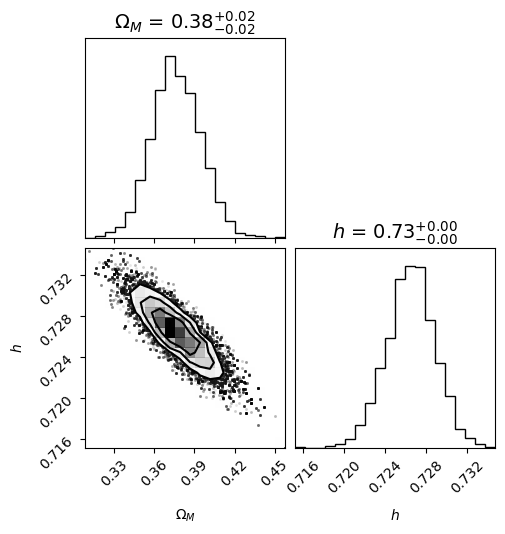

In [100]:
fig = corner.corner(
    np.array(samples10), labels=[r'$\Omega_M$', r'$h$'], show_titles=True, title_kwargs={"fontsize": 14}
)

In [107]:
concise_fit_samples = np.array(samples10)

In [116]:
np.mean(concise_fit_samples[:, 1])

0.7264568127090953

## Test the converge of the chain using Gelman Rubin Criteria
Our chains look like they have converged well based on the fits. However, it is good to check the convergence with a formula. Gelman Rubin Criteria is what was recommend in the lecture. ChatGPT does an awesome job of describing it. The advantage of having a simple algorithm is that you can run additional tests on it explicitly by creating multiple chains manually. Paraphrasing from ChatGPT.

The Gelman-Rubin diagnostic is a statistical measure used to assess the convergence of Markov Chain Monte Carlo (MCMC) simulations. It compares the variance between multiple chains to the variance within each chain to determine if the chains have converged to the target distribution.

#### Computation Steps of Gelman Rubin

1. **Multiple Chains:** Run several MCMC chains independently, typically recommended to start from overdispersed initial values, and continue for a sufficient number of iterations.

2. **Calculate the Within-Chain Variance (W):** 
    $$ W = \frac{1}{m} \sum_{j=1}^m s_j^2 $$
   where $ m $ is the number of chains, and $ s_j^2 $ is the variance of the $ j $-th chain.

3. **Calculate the Between-Chain Variance (B):** 
    $$ B = \frac{n}{m-1} \sum_{j=1}^m (\bar{\theta}_j - \bar{\theta})^2 $$
   where $ n $ is the number of iterations per chain, $ \bar{\theta}_j $ is the mean of the $ j $-th chain, and $ \bar{\theta} $ is the overall mean across all chains.

4. **Estimate the Variance of the Target Distribution:**
    $$ \hat{\text{Var}}^+(\theta) = \left(1 - \frac{1}{n}\right) W + \frac{1}{n} B $$

5. **Calculate the Potential Scale Reduction Factor (PSRF):**
    $$ \hat{R} = \sqrt{\frac{\hat{\text{Var}}^+(\theta)}{W}} $$

#### Interpretation

The PSRF, $ \hat{R}$ , provides a measure of how much additional sampling could reduce the potential scale of the estimates. Values of $ \hat{R}$ close to 1 suggest that the chains have converged sufficiently. Common thresholds for convergence are $ \hat{R} < 1.1 $ or $ \hat{R} < 1.05$. Values significantly greater than 1 indicate that the chains may require more iterations to converge.

### Run 5 chains with initial conditions located at the different parts of the posterior
We will run 5 chains where the step size was the expected standard deviation of the posterior distribution. That did give consistent results with the suggested start acceptance rate of $\frac{2.4\sigma}{\sqrt{d}}$ where $\sigma$ is the scale of the target distribution amd $d$ is the number of parameters.

In [119]:
# first verify that the simplified dataset works
samples11, acceptance11 = find_mcmc_acceptance(log_likelihood_fast, proposal_distribution,
                                           step=[0.02, 0.02], initial=[0.5, 0.5],
                                           num_steps=100000, burnin=0.1, log=True,
                                           z_data=z_data2, mu_data=mu_data2,
                                             cov_inv=inv_cov_matrix2, log_det=log_det, cov_len=cov2_len)

MCMC Progress:   0%|                                 | 0/100000 [00:00<?, ?it/s]/var/folders/ss/xpl4rz6x099dxtmc5h_96sr00000gn/T/ipykernel_10827/2353296613.py:13: RuntimeWarning: overflow encountered in exp
  accept_crit = np.exp(delta_log_likeli)  # exp of difference for log likelihood ratio
MCMC Progress: 100%|██████████████████| 100000/100000 [00:55<00:00, 1790.57it/s]


In [120]:
samples11 = np.array(samples11)

In [121]:
# first verify that the simplified dataset works
samples12, acceptance12 = find_mcmc_acceptance(log_likelihood_fast, proposal_distribution,
                                           step=[0.02, 0.02], initial=[0.2, 0.8],
                                           num_steps=100000, burnin=0.1, log=True,
                                           z_data=z_data2, mu_data=mu_data2,
                                             cov_inv=inv_cov_matrix2, log_det=log_det, cov_len=cov2_len)

MCMC Progress: 100%|██████████████████| 100000/100000 [00:55<00:00, 1809.15it/s]


In [122]:
samples12 = np.array(samples12)

In [123]:
# first verify that the simplified dataset works
samples13, acceptance13 = find_mcmc_acceptance(log_likelihood_fast, proposal_distribution,
                                           step=[0.02, 0.02], initial=[0.2, 0.8],
                                           num_steps=100000, burnin=0.1, log=True,
                                           z_data=z_data2, mu_data=mu_data2,
                                             cov_inv=inv_cov_matrix2, log_det=log_det, cov_len=cov2_len)

MCMC Progress: 100%|██████████████████| 100000/100000 [00:55<00:00, 1792.55it/s]


In [124]:
samples13 = np.array(samples13)

In [125]:
# first verify that the simplified dataset works
samples14, acceptance14 = find_mcmc_acceptance(log_likelihood_fast, proposal_distribution,
                                           step=[0.02, 0.02], initial=[0.3, 0.7],
                                           num_steps=100000, burnin=0.1, log=True,
                                           z_data=z_data2, mu_data=mu_data2,
                                             cov_inv=inv_cov_matrix2, log_det=log_det, cov_len=cov2_len)

MCMC Progress: 100%|██████████████████| 100000/100000 [00:55<00:00, 1789.86it/s]


In [126]:
samples14 = np.array(samples14)

Lets show that we still get the same values wherever we start. This lets us be more confident about our results.

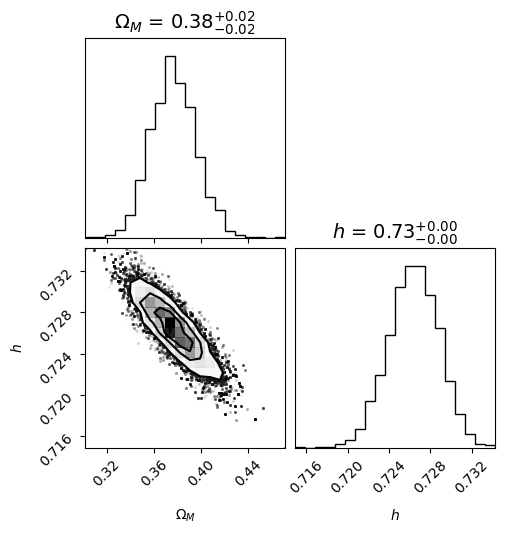

In [133]:
fig = corner.corner(
    samples11, labels=[r'$\Omega_M$', r'$h$'], show_titles=True, title_kwargs={"fontsize": 14}
)

Now checking although our acceptance rate is consistent with initial suggetion of Gelman, Roberts, and Gilks (1995), the target acceptance rate should be around 1/e to 23.4% suggested by Graves 2011.

In [135]:
# our current acceptance is 6 percent
acceptance13

0.06161111111111111

In [138]:
chains = [samples10, samples11, samples12, samples13, samples14]

In [150]:
def gelman_rubin(chains, thinning=1):
    """
    Computes the Gelman-Rubin diagnostic for multiple MCMC chains with optional thinning.

    Parameters:
    chains (list of ndarray): A list where each element is an ndarray of shape (n, m),
                              with 'n' being the number of samples and 'm' the number of parameters.
                              Each ndarray is the output of one MCMC chain.
    thinning (int): The interval at which to thin the chains. A value of 1 means no thinning.

    Returns:
    ndarray: An array of R-hat values, one for each parameter.
    """
    # Apply thinning and convert list of chains to an ndarray of shape (num_chains, num_samples, num_parameters)
    thinned_chains = [chain[::thinning] for chain in chains]
    chains = np.array(thinned_chains)
    num_chains, num_samples, num_parameters = chains.shape

    # Calculate the mean of each chain
    chain_means = np.mean(chains, axis=1)

    # Calculate the mean of the means across chains for each parameter
    mean_of_means = np.mean(chain_means, axis=0)

    # Calculate the between-chain variance (B/n)
    B = np.sum((chain_means - mean_of_means)**2, axis=0) * num_samples / (num_chains - 1)

    # Calculate the within-chain variances (W)
    W = np.sum([(chains[i] - chain_means[i])**2 for i in range(num_chains)], axis=(0, 1)) / (num_chains * (num_samples - 1))

    # Estimate of the variance of the target distribution (sigma^2_plus)
    sigma2_plus = ((num_samples - 1) / num_samples) * W + (1 / num_samples) * B

    # Calculate the potential scale reduction factor (R-hat)
    R_hat = np.sqrt(sigma2_plus / W)

    return R_hat



Our values of convergence are very close to one which means our chains haev successfully converged. Because of the high step size a thinning of 15 ends up being enough to get rid of high correlation. It is also good to see that 100000 iterations with 10000 burnin ends up being enough for convergence.

In [152]:
r_hat_values = gelman_rubin(chains, thinning=15)
r_hat_values

array([1.00095164, 1.00067777])

### Improving the acceptance rate
The acceptance rate depends mostly on the step size (after initial burnin period). Thus we can decrease the step size to increase the acceptance rate.

In [153]:
# first verify that the simplified dataset works
samples16, acceptance16 = find_mcmc_acceptance(log_likelihood_fast, proposal_distribution,
                                           step=[0.01, 0.01], initial=[0.5, 0.5],
                                           num_steps=100000, burnin=0.1, log=True,
                                           z_data=z_data2, mu_data=mu_data2,
                                             cov_inv=inv_cov_matrix2, log_det=log_det, cov_len=cov2_len)

MCMC Progress:   0%|                                 | 0/100000 [00:00<?, ?it/s]/var/folders/ss/xpl4rz6x099dxtmc5h_96sr00000gn/T/ipykernel_10827/2353296613.py:13: RuntimeWarning: overflow encountered in exp
  accept_crit = np.exp(delta_log_likeli)  # exp of difference for log likelihood ratio
MCMC Progress: 100%|██████████████████| 100000/100000 [00:55<00:00, 1796.82it/s]


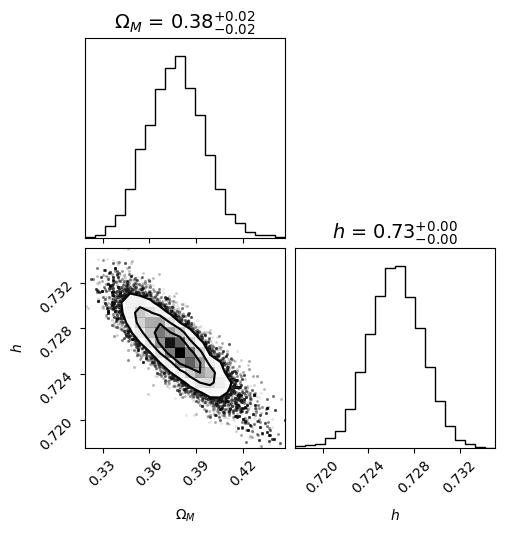

In [154]:
fig = corner.corner(
    np.array(samples16), labels=[r'$\Omega_M$', r'$h$'], show_titles=True, title_kwargs={"fontsize": 14}
)

In [156]:
acceptance16

0.13978888888888888

We see that the acceptance rate increased by a factor of 2 once the step size is halfed. We can half the step size once again to get an acceptance rate that is higher. Averaging the papers and the lecture, an acceptance rate around 28% should be what we aim for.

In [157]:
# first verify that the simplified dataset works
samples17, acceptance17 = find_mcmc_acceptance(log_likelihood_fast, proposal_distribution,
                                           step=[0.005, 0.005], initial=[0.5, 0.5],
                                           num_steps=200000, burnin=10000, log=True,
                                           z_data=z_data2, mu_data=mu_data2,
                                             cov_inv=inv_cov_matrix2, log_det=log_det, cov_len=cov2_len)

MCMC Progress:   0%|                                 | 0/200000 [00:00<?, ?it/s]/var/folders/ss/xpl4rz6x099dxtmc5h_96sr00000gn/T/ipykernel_10827/2353296613.py:13: RuntimeWarning: overflow encountered in exp
  accept_crit = np.exp(delta_log_likeli)  # exp of difference for log likelihood ratio
MCMC Progress: 100%|██████████████████| 200000/200000 [01:50<00:00, 1810.34it/s]


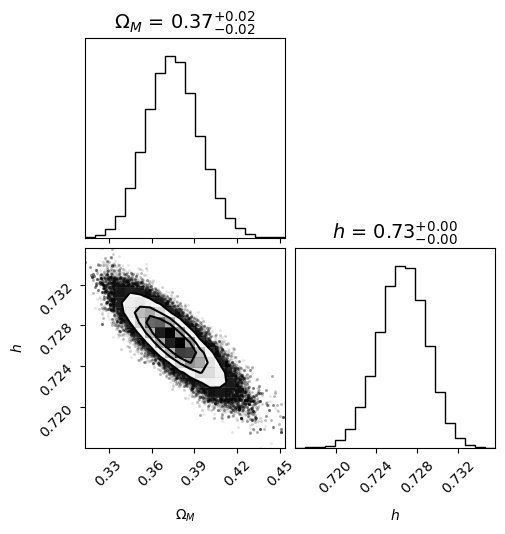

In [158]:
fig = corner.corner(
    np.array(samples17), labels=[r'$\Omega_M$', r'$h$'], show_titles=True, title_kwargs={"fontsize": 14}
)

In [159]:
acceptance17

0.2795578947368421

When we halfed the step size once again we got an acceptance rate around the desired value. The numbers that are titles of the corner plots should be disregarded as they only round the value to two decimal points and the mean value of $\Omega_M \approx 0.375$ from the simulations.

## Test convergence with chains with higher acceptance rate
Now, we will test the convergence of the higher acceptance rate chains. We will initialize chains that start from far away from the distribution and see if they still yield the same values.

In [167]:
# define in an initial position for the two parameters
initial_simple = [0.32, 0.7]
# Define a list of initial positions that will be sampled
# by adding a random number from a gaussian that has a standard
# 10 times the expected standard deviation. This will let the algorithm
# explore the parameter space fully.
initial_pos_simple = initial_simple + 0.1*np.random.randn(10, 2)

In [170]:
initial_pos_simple

array([[0.27812303, 0.63892956],
       [0.23159172, 0.8134723 ],
       [0.52967615, 0.52712812],
       [0.30708597, 0.65159747],
       [0.24146989, 0.67688525],
       [0.20295705, 0.67664681],
       [0.32368333, 0.73805545],
       [0.49011319, 0.72693018],
       [0.30646312, 0.62208411],
       [0.30935464, 0.76622913]])

In [171]:
# run 10 chains
sample_list = []
acceptance_list = []
for i in range(10):
    # get acceptances
    samples, acceptance = find_mcmc_acceptance(log_likelihood_fast, proposal_distribution,
                                               step=[0.005, 0.005], initial=initial_pos_simple[1],
                                               num_steps=200000, burnin=10000, log=True,
                                               z_data=z_data2, mu_data=mu_data2,
                                                 cov_inv=inv_cov_matrix2, log_det=log_det, cov_len=cov2_len)
    sample_list.append(samples)
    acceptance_list.append(acceptance)

MCMC Progress: 100%|██████████████████| 200000/200000 [01:56<00:00, 1719.57it/s]


In [172]:
sample_arrays = [np.array(sample_list) for sample_list in sample_list]

In [176]:
# get the convergence of samples
r_hat_high_accept = gelman_rubin(sample_arrays, thinning=100)
r_hat_high_accept

array([1.00011472, 1.0001089 ])

We see that the samples converge sufficiently.

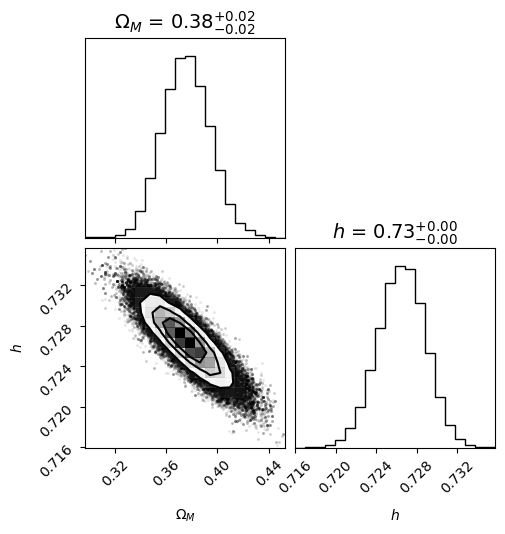

In [178]:
fig = corner.corner(
    sample_arrays[3], labels=[r'$\Omega_M$', r'$h$'], show_titles=True, title_kwargs={"fontsize": 14}
)

/var/folders/ss/xpl4rz6x099dxtmc5h_96sr00000gn/T/ipykernel_10827/3426631614.py:31: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_yticklabels([f"{round(tick, 1)}" for tick in new_ticks])
/var/folders/ss/xpl4rz6x099dxtmc5h_96sr00000gn/T/ipykernel_10827/3426631614.py:31: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_yticklabels([f"{round(tick, 1)}" for tick in new_ticks])


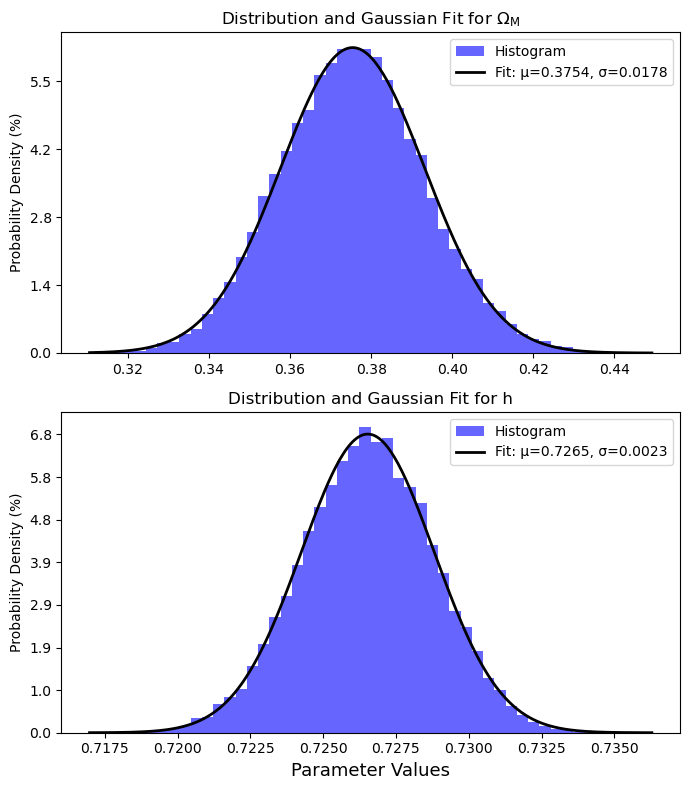

In [192]:
fig_test9, axes9 = plot_histograms_with_gaussian_fit_and_stats_fancy(sample_arrays[8], [r"$\Omega_\text{M}$", "h"])

In [185]:
fig_test9.savefig('final_gaussian_fits_2D_manual_algorithm.pdf', bbox_inches='tight')

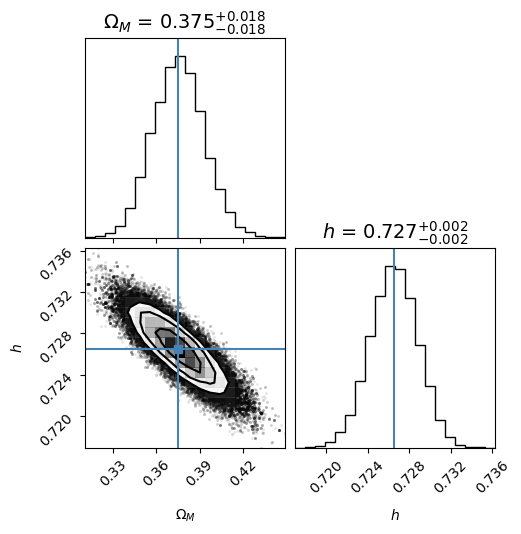

In [204]:
fig_final = corner.corner(
    sample_arrays[8], labels=[r'$\Omega_M$', r'$h$'], truths=[0.375, 0.7265], show_titles=True, title_kwargs={"fontsize": 14}, title_fmt='.3f'
)

In [205]:
fig_final.savefig('final_corner_fits_2D_manual_algorithm.pdf', bbox_inches='tight')

## Comparison of the analysis with emcee

In [212]:
samples_emcee_flat = np.load('two_parameter_emcee_flat.npy')
samples_emcee = np.load('two_parameter_emcee.npy')

In [222]:
samples_emcee = samples_emcee.transpose(1,0,2)

In [236]:
r_hat_high_emcee = gelman_rubin(list(samples_emcee), thinning=37)
r_hat_high_emcee

array([0.99997787, 1.00000483])

/var/folders/ss/xpl4rz6x099dxtmc5h_96sr00000gn/T/ipykernel_10827/3426631614.py:31: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_yticklabels([f"{round(tick, 1)}" for tick in new_ticks])
/var/folders/ss/xpl4rz6x099dxtmc5h_96sr00000gn/T/ipykernel_10827/3426631614.py:31: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_yticklabels([f"{round(tick, 1)}" for tick in new_ticks])


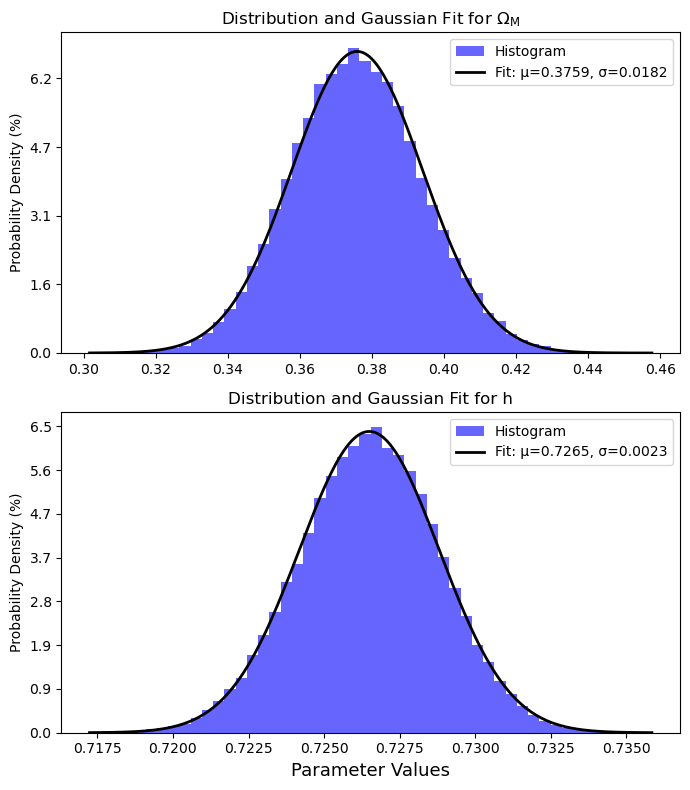

In [226]:
fig_emcee, axes_emcee = plot_histograms_with_gaussian_fit_and_stats_fancy(samples_emcee_flat, [r"$\Omega_\text{M}$", "h"])

In [227]:
fig_emcee.savefig('emcee_fits_best_2D.pdf', bbox_inches='tight')

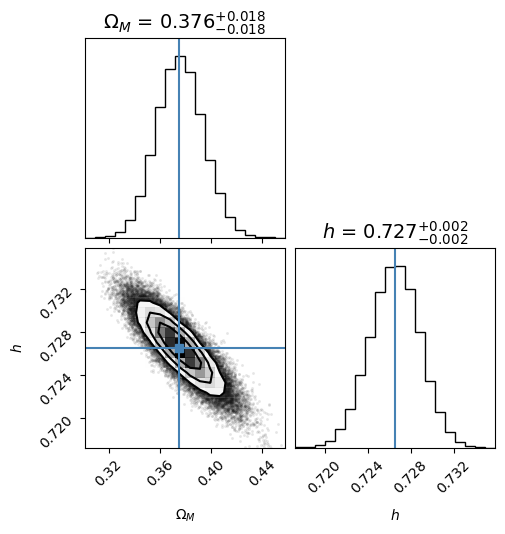

In [228]:
figemcee_corner = corner.corner(
    samples_emcee_flat, labels=[r'$\Omega_M$', r'$h$'], truths=[0.375, 0.7265], show_titles=True, title_kwargs={"fontsize": 14}, title_fmt='.3f'
)

In [229]:
figemcee_corner.savefig('emcee_corner_best_2D.pdf', bbox_inches='tight')

In [238]:
np.mean(acceptance_list)

0.2795578947368421